# Importing Libraries

In [13]:
%pip install -q -U keras_tuner
%pip install opencv-python
%pip install -q -U tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\merwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\merwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\merwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import random
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

# Prepare the training and testing datasets and Resizing

In [15]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']

#resizing image to 150*150 pixel
image_size = 150

#Training dataset
for i in labels:
    folderPath = os.path.join(os.getcwd(), 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
#Testing dataset
for i in labels:
    folderPath=os.path.join(os.getcwd(), 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1457/1457 [00:03<00:00, 391.87it/s]


In [18]:
print(f"Total number of images in X_train: {X_train.shape[0]}")
print(f"Total number of labels in y_train: {y_train.shape[0]}")

print(f"Shape of images: {X_train.shape[1:]}")

Total number of images in X_train: 7023
Total number of labels in y_train: 7023
Shape of images: (150, 150, 3)


# visulization of tumor type counts


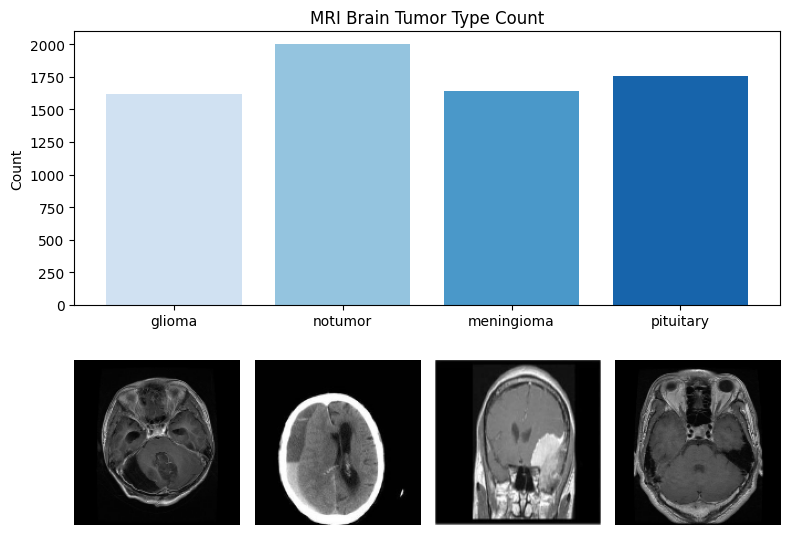

In [19]:
label_counts = {} 
for label in labels:
    count = np.sum(y_train == label)
    label_counts[label] = count  # Add the count to the dictionary
    
plt.figure(figsize=(8, 6))

colors = sns.color_palette("Blues", len(labels))
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.ylabel('Count')
plt.title('MRI Brain Tumor Type Count')

# Plot sample images from each Type
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) #location of image
            plt.imshow(X_train[j]) 
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

# Data Splitting

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# One-Hot Encoding

In [93]:
y_train = np.array(pd.get_dummies(y_train))
y_valid = np.array(pd.get_dummies(y_valid))
y_test = np.array(pd.get_dummies(y_test))

In [94]:
# Print shapes of splits
print(f'X_train shape: {X_train.shape}\n'
      f'y_train shape: {y_train.shape}\n'
      f'X_test shape: {X_test.shape}\n'
      f'y_test shape: {y_test.shape}\n'
      f'X_valid shape: {X_valid.shape}\n'
      f'y_valid shape: {y_valid.shape}')

X_train shape: (5688, 150, 150, 3)
y_train shape: (5688, 4)
X_test shape: (703, 150, 150, 3)
y_test shape: (703, 4)
X_valid shape: (632, 150, 150, 3)
y_valid shape: (632, 4)


# Pixels Normalization



In [95]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


# Data Augmentation

In [97]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set seed for reproducibility in augmentation
datagen.fit(X_train, seed=42)

# Hyperparameter Tuning

In [98]:
def hyperparameter_tuning(model_builder, X_train, y_train):
    
    tuner = kt.Hyperband(
        model_builder,
        objective='val_accuracy',
        factor=3,
        max_epochs=10,
        directory='tuner_results',  # specify directory to save results
        project_name='hyperparameter_tuning'
    )
    
    tuner.search(
        X_train, 
        y_train, 
        validation_split=0.1, 
        verbose=1
    )
    
    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Build the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)
    
    return best_model, best_hps

# Callbacks

In [99]:
my_callbacks=[
        TensorBoard(log_dir='logs'),
        #Saves the model with the best validation accuracy during training.
        ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
        #Reduces the learning rate when validation accuracy plateaus.
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_delta=0.0001, verbose=1),
        #Stops training early if validation loss doesn't improve for a number of epochs.
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]

# VGG16
VGG16 is a convolutional neural network architecture with 16 deep layers, 13 convolutional layers, 3 fully connected layers, and 5 max pooling layers

The model starts with an input layer specifying the shape (150x150x3) for RGB images.
It then has several convolutional layers (Conv2D) Each of them uses 3x3 filters (kernels) with padding to preserve spatial dimensions (i.e., output size equal to input size).

followed by max pooling and dropout layers.
The number of filters increases from 16 to 32 to 64 as the network deepens.
After the convolutional layers, the output is flattened and passed through dense layers.
The final layer has 4 neurons with softmax activation for 4-class classification..

In [100]:
# model builder function for hyperparameter tuning
def vgg16_model_builder(hp):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) #not include the fully connected layers
    
    # Make initial layers trainable 
    for layer in vgg16.layers[:hp.Int('trainable_layers', min_value=5, max_value=len(vgg16.layers), step=5)]:
        layer.trainable = True

    # Add custom layers
    x = GlobalAveragePooling2D()(vgg16.output)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    vgg16_model = Model(inputs=vgg16.input, outputs=output)

    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    vgg16_model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    vgg16_model.summary()
    return vgg16_model

# VGG16 Training 

In [101]:
vgg16_model, vgg16_best_hps = hyperparameter_tuning(vgg16_model_builder,X_train,y_train)

Reloading Tuner from tuner_results/hyperparameter_tuning/tuner0.json


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 14,847,044 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
vgg16_history =vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=15),
    validation_data=(X_valid,y_valid),
    epochs=20, 
    callbacks=my_callbacks
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5622 - loss: 0.9639
Epoch 1: val_accuracy improved from -inf to 0.91139, saving model to best_model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 58s 136ms/step - accuracy: 0.5626 - loss: 0.9632 - val_accuracy: 0.9114 - val_loss: 0.2448 - learning_rate: 1.0000e-04
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8891 - loss: 0.3325
Epoch 2: val_accuracy improved from 0.91139 to 0.92089, saving model to best_model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8891 - loss: 0.3324 - val_accuracy: 0.9209 - val_loss: 0.2015 - learning_rate: 1.0000e-04
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9056 - loss: 0.2662
Epoch 3: val_accuracy improved from 0.92089 to 0.95095, saving model to best_model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9056 - loss: 0.2661 - val_accuracy: 0.9509 - val_loss: 0.1196 - learning_rate: 1.0000e-04
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━

# VGG16 Evaluation 

In [103]:
vgg16_eval = vgg16_model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", vgg16_eval)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9871 - loss: 0.0535
[test loss, test accuracy]: [0.06484735012054443, 0.9843527674674988]


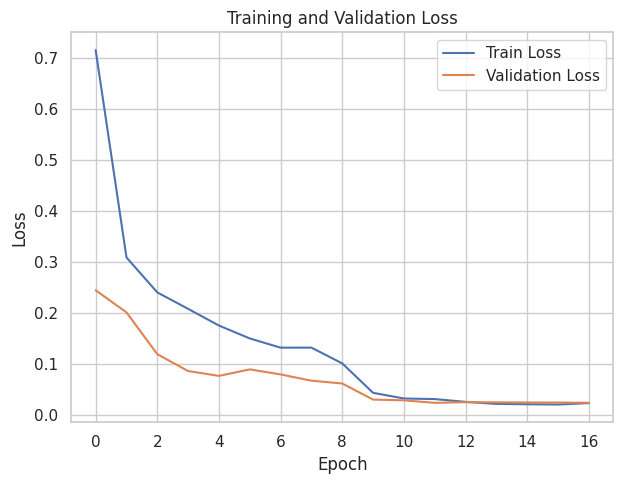

In [104]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [105]:
# Save the final model
vgg16_model.save("vgg16_best_model.keras")
vgg16_model = tf.keras.models.load_model("vgg16_best_model.keras")  # Load the best saved model

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


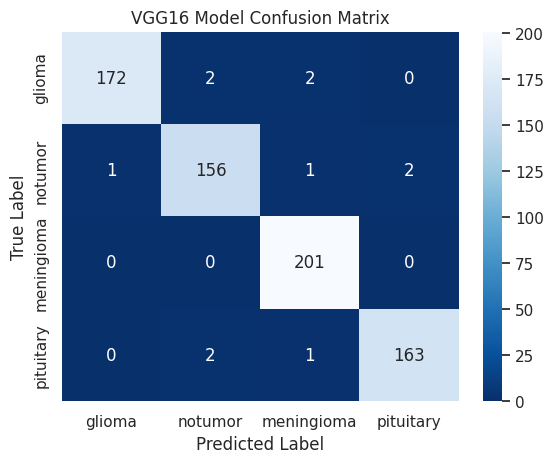

In [106]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(vgg16_model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('VGG16 Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       176
           1       0.97      0.97      0.97       160
           2       0.98      1.00      0.99       201
           3       0.99      0.98      0.98       166

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Predicted label: meningioma
Confidence: 100.00%
Actual label: meningioma


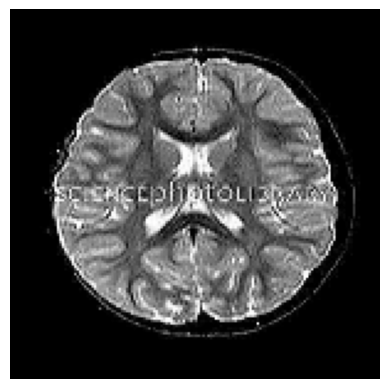

In [113]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

print(classification_report(y_true_test, y_pred_test))

random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = vgg16_model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

print(f"\nPredicted label: {predicted_label}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Actual label: {labels[y_true_test[random_index]]}")

plt.imshow(random_img)
plt.axis('off')
plt.show()

 The model predicted a "meningioma tumor" with 100.00% confidence, correctly matching the actual label.


# ResNet-101 

ResNet-101 is a 101-layer deep convolutional neural network, offers a pretrained version trained on over a million images from the ImageNet database. It excels in classifying images over 1000 object categories, demonstrating its adaptability in recognizing different objects and animals. ResNet-101, with an image input size of 224-by-224, uses extensive feature representations, making it a strong choice for a variety of image classification problems.

In [57]:
def resnet101_model_builder(hp):
    resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    # Build the custom model on top of the ResNet101 base
    x = GlobalAveragePooling2D()(resnet.output)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    resnet101_model = Model(inputs=resnet.input, outputs=output)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    resnet101_model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    resnet101_model.summary()
    
    return resnet101_model

# ResNet-101 Training 

In [58]:
resnet101_model, resnet_best_hps = hyperparameter_tuning(resnet101_model_builder,X_train,y_train)

Reloading Tuner from tuner_results/hyperparameter_tuning/tuner0.json


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 43,577,924 (166.24 MB)

 Trainable params: 43,472,580 (165.83 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [59]:
# Use validation instead of validation_split-0.1
resnet101_history = resnet101_model.fit(
    datagen.flow(X_train, y_train, batch_size=15),
    validation_data=(X_valid, y_valid),  # Use the explicit validation set
    epochs=10,
    verbose=1,
    callbacks=my_callbacks)

Epoch 1/10
317/380 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.7713 - loss: 0.6122

I0000 00:00:1734101212.023944     140 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_49', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_48', 40 bytes spill stores, 40 bytes spill loads



380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7862 - loss: 0.5771
Epoch 1: val_accuracy did not improve from 0.29589
380/380 ━━━━━━━━━━━━━━━━━━━━ 220s 311ms/step - accuracy: 0.7864 - loss: 0.5766 - val_accuracy: 0.2722 - val_loss: 4.7721 - learning_rate: 1.0000e-04
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9303 - loss: 0.2092
Epoch 2: val_accuracy improved from 0.29589 to 0.68987, saving model to best_model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 71s 185ms/step - accuracy: 0.9303 - loss: 0.2092 - val_accuracy: 0.6899 - val_loss: 0.9279 - learning_rate: 1.0000e-04
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9478 - loss: 0.1578
Epoch 3: val_accuracy improved from 0.68987 to 0.86392, saving model to best_model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 71s 185ms/step - accuracy: 0.9478 - loss: 0.1578 - val_accuracy: 0.8639 - val_loss: 0.4117 - learning_rate: 1.0000e-04
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9636 

# ResNet-101 Evaluation 

In [75]:
resnet101_eval = resnet101_model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", resnet101_eval)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9910 - loss: 0.0424
[test loss, test accuracy]: [0.049433548003435135, 0.9900426864624023]


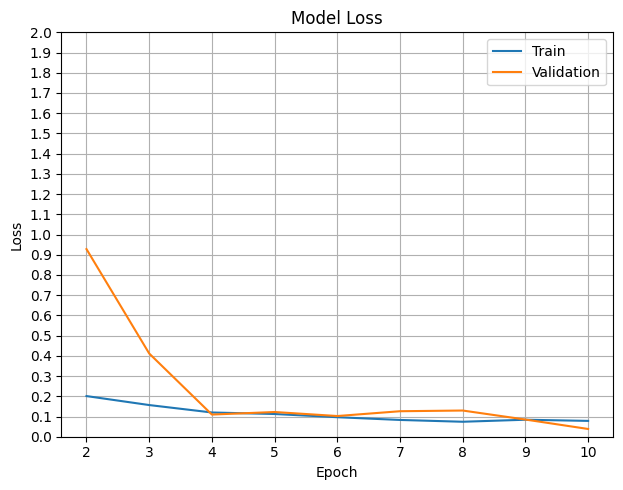

In [64]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), resnet101_history.history['loss'][1:10], label='Train')
plt.plot(range(2, 11), resnet101_history.history['val_loss'][1:10], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 2)  # Adjust this range as needed
plt.yticks(np.arange(0, 2.1, 0.1))

plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


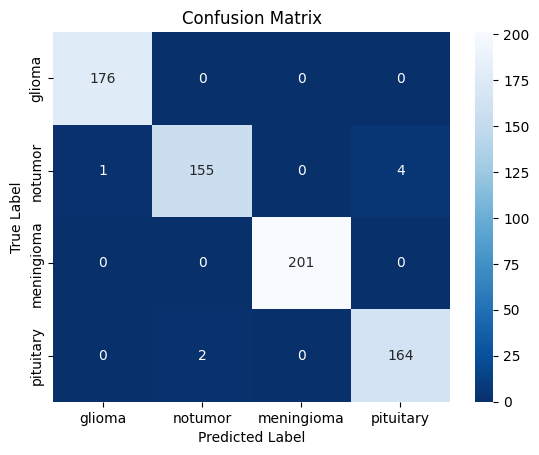

In [65]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(resnet101_model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       176
           1       0.99      0.97      0.98       160
           2       1.00      1.00      1.00       201
           3       0.98      0.99      0.98       166

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Predicted label: pituitary
Confidence: 100.00%
Actual label: pituitary


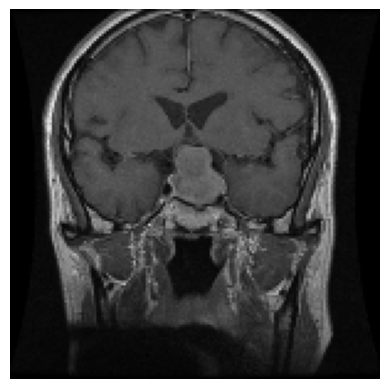

In [66]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

print(classification_report(y_true_test, y_pred_test))

random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = resnet101_model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

print(f"\nPredicted label: {predicted_label}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Actual label: {labels[y_true_test[random_index]]}")

plt.imshow(random_img)
plt.axis('off')
plt.show()

 The model predicted a "pituitary tumor" with 100.00% confidence, correctly matching the actual label.


# ResNet-101 vs VGG16
ResNet-101 typically preform better than VGG16 on tasks like brain tumor classification for several key reasons related to its architecture and the way it handles complex features in images.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


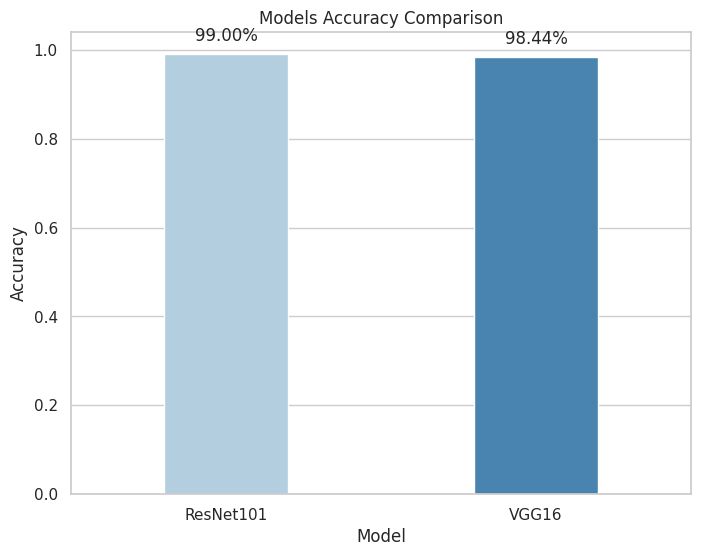

In [120]:
plt.figure(figsize=(8, 6))
barplot = sns.barplot(
    x=['ResNet101', 'VGG16'],
    y=[resnet101_eval[1], vgg16_eval[1]],
    palette='Blues', 
    width=0.4  # Reduce bar width
)

# Add accuracy values on top of the bars
for i, v in enumerate([resnet101_eval[1], vgg16_eval[1]]):
    barplot.text(i, v + 0.02, f'{v*100:.2f}%', ha='center', va='bottom', fontsize=12)

plt.title('Models Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()

This indicates that both models perform well.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


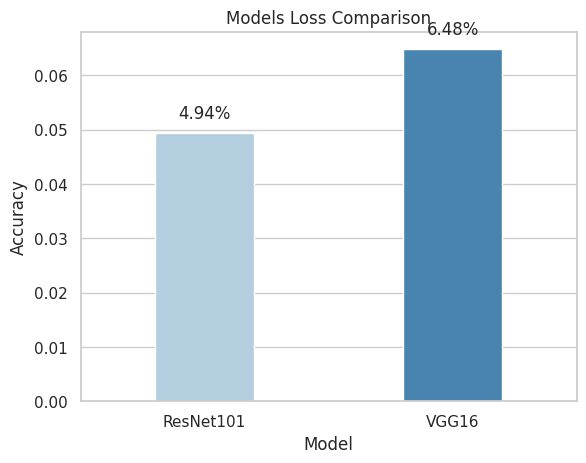

In [125]:
# Create the barplot
barplot = sns.barplot(
    x=['ResNet101', 'VGG16'],
    y=[resnet101_eval[0], vgg16_eval[0]],
    palette='Blues',
    width=0.4  )

# Add accuracy values on top of the bars
for i, v in enumerate([resnet101_eval[0], vgg16_eval[0]]):
    barplot.text(i, v + 0.002, f'{v*100:.2f}%', ha='center', va='bottom', fontsize=12)

plt.title('Models Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()
